## Dependencies

In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from src.dataSampling import SequenceGenerator

## Loading data

### Load the data

In [26]:
data = pd.read_csv('./data/hpq.us.txt')

In [27]:
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0


## Data exploration

In [28]:
data = data.sort_values('Date')


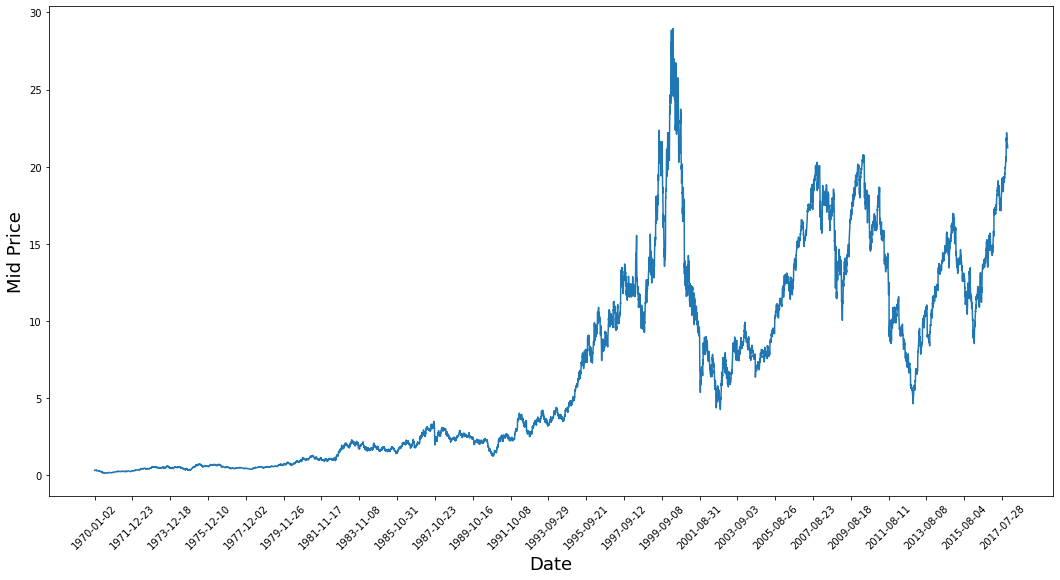

In [29]:
plt.figure(figsize=(18,9))

plt.plot(range(data.shape[0]),(data['High']+data['Low'])/2)
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

plt.show()

In [30]:
data.pop("Date")
data.pop("OpenInt")

0        0
1        0
2        0
3        0
4        0
        ..
12070    0
12071    0
12072    0
12073    0
12074    0
Name: OpenInt, Length: 12075, dtype: int64

## Spliting data

In [31]:
high_prices = data.loc[:,'High'].values
low_prices = data.loc[:,'Low'].values

mid_prices = (high_prices+low_prices) / 2.0

In [32]:
mid_prices

array([ 0.30627 ,  0.311975,  0.311905, ..., 21.355   , 21.275   ,
       21.225   ])

In [33]:
mid_prices.shape

(12075,)

In [34]:
data['Mid'] = pd.DataFrame(mid_prices)

In [35]:
data.head()

,Open,High,Low,Close,Volume,Mid
0,0.30627,0.30627,0.30627,0.30627,2441124,0.306270
1,0.30627,0.31768,0.30627,0.31385,6219848,0.311975
2,0.31385,0.31385,0.30996,0.30996,4447522,0.311905
3,0.31385,0.31385,0.31385,0.31385,1872638,0.313850
4,0.31385,0.31768,0.31385,0.31385,4280330,0.315765


In [36]:
train_df = data.iloc[:round(0.8*data.shape[0])]
test_df = data.iloc[round(0.8*data.shape[0]):]

In [37]:
# train_data = mid_prices[:round(0.8*mid_prices.shape[0])]
# test_data = mid_prices[round(0.8*mid_prices.shape[0]):]

### Normalizing data

In [38]:
# scaler = MinMaxScaler()

# train_data = train_data.reshape(-1,1)
# test_data = test_data.reshape(-1,1)

In [39]:
# train_data[:10]

In [40]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [41]:
wide_window = SequenceGenerator(
    
    input_width=24,
    label_width=24, 
    shift=1,
    train_df=train_df,
    test_df=test_df,
    label_column=['Mid'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Mid']

In [42]:
train_df.head()

,Open,High,Low,Close,Volume,Mid
0,-0.831344,-0.830434,-0.832176,-0.831264,-0.921700,-0.831359
1,-0.831344,-0.828453,-0.832176,-0.829925,-0.651799,-0.830350
2,-0.830004,-0.829118,-0.831513,-0.830612,-0.778390,-0.830363
3,-0.830004,-0.829118,-0.830813,-0.829925,-0.962306,-0.830019
4,-0.830004,-0.828453,-0.830813,-0.829925,-0.790332,-0.829681


## Build and Test the model

### LSTM

In [43]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

### Compile and fit the model function - 20 Epochs

In [44]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  
  early_stopping = tf.keras.callbacks.EarlyStopping(
    
    monitor='val_loss',
    patience=patience,
    mode='min'
  )

  model.compile(
    
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
  )

  history = model.fit(
    
    window.train, 
    epochs=MAX_EPOCHS,
    validation_data=window.test,
    callbacks=[early_stopping]
  )
  
  return history

## Train the model

In [45]:
history = compile_and_fit(model,window=wide_window)

Epoch 1/20
302/302 [==============================] - 5s 9ms/step - loss: 0.1175 - mean_absolute_error: 0.1724 - val_loss: 0.0427 - val_mean_absolute_error: 0.1074
Epoch 2/20
302/302 [==============================] - 2s 8ms/step - loss: 0.0115 - mean_absolute_error: 0.0527 - val_loss: 0.0155 - val_mean_absolute_error: 0.0700
Epoch 3/20
302/302 [==============================] - 2s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0358 - val_loss: 0.0064 - val_mean_absolute_error: 0.0499
Epoch 4/20
302/302 [==============================] - 2s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0261 - val_loss: 0.0034 - val_mean_absolute_error: 0.0381
Epoch 5/20
302/302 [==============================] - 3s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0220 - val_loss: 0.0027 - val_mean_absolute_error: 0.0347
Epoch 6/20
302/302 [==============================] - 3s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0198 - val_loss: 0.0024 - val_mean_absolute_error: 0.0323
Epoch 7/20
302/3

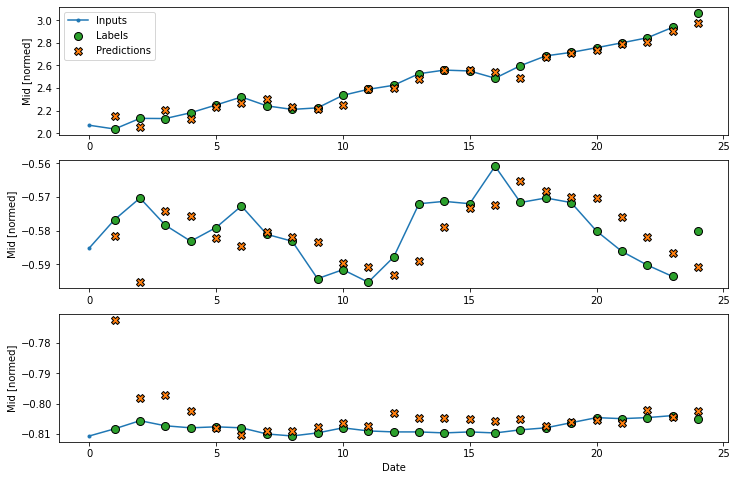

In [46]:
wide_window.plot(model=model,plot_col="Mid")